# 线性回归的从零开始实现
在这一节中，**我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**。

In [2]:
import random
import torch
import warnings
warnings.filterwarnings('ignore')

# 生成数据集
我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

你可以将$\epsilon$视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。

In [8]:
def synthetic_data(w, b, num_examples):
    """生成y=wx+b+$\epsilon$"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [9]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，[**`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）**]。

In [12]:
features[0], labels[0]

(tensor([0.2990, 2.0853]), tensor([-2.3049]))

通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


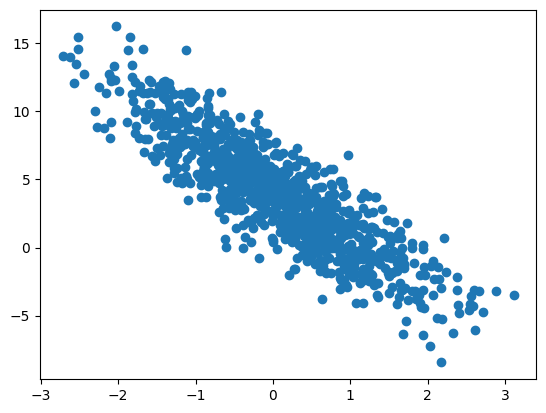

In [15]:
import matplotlib.pyplot as plt

plt.scatter(features[:, 1].detach().numpy(), labels[:].detach().numpy())

# 读取数据集
训练模型时需要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新模型，下面定义一个函数，它能打乱数据集中的样本并以小批量方式获取数据。

下面我们定义一个[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = labels.shape[0]
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [17]:
batch_size = 10
# 打印一个batch数据
for X ,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2754,  0.0226],
        [ 0.3537,  0.2106],
        [ 0.2254, -0.1720],
        [ 1.2952, -0.5005],
        [ 0.5906, -0.1933],
        [ 1.0464, -2.0580],
        [-1.8112, -0.2567],
        [ 0.0506,  0.5934],
        [ 1.6876,  0.9114],
        [ 0.7133, -0.8361]]) 
 tensor([[ 4.6800],
        [ 4.1991],
        [ 5.2282],
        [ 8.4941],
        [ 6.0386],
        [13.2958],
        [ 1.4541],
        [ 2.2900],
        [ 4.4996],
        [ 8.4814]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

# 初始化模型参数
从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [19]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。我们使用自动微分来计算梯度。

# 定义模型
* 输入：特征矩阵X，权重w，偏置b
* 输出：y = wx + b

注意这里偏置b是一个标量，运用广播机制把它加到向量的每一项上去。

In [30]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 定义损失函数
$loss =\frac{1}{2}(\hat{y}-y)^2  $

In [38]:
def squared_loss(y_hat, y):
    """均方误差"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  

# 定义优化算法
在每一步中，使用数据集中随机抽取的一小批数据，然后根据参数计算梯度。接下来，朝着减小损失的方向更新我们的参数。下面的函数实现小批量随机梯度下降更新，输入是模型参数集合，学习率，批量大小。
每 一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [37]:
def sgd(params, lr, batch_size):
    """SGD"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 训练

In [40]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [41]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        predict = net(X, w, b)
        l = loss(predict, y)
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_1 = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_1.mean()):f}')
        

epoch 1, loss 0.632041
epoch 2, loss 0.001804
epoch 3, loss 0.000058


In [44]:
true_w - w.reshape(true_w.shape)

tensor([ 0.0011, -0.0007], grad_fn=<SubBackward0>)

In [45]:
true_b - b

tensor([0.0026], grad_fn=<RsubBackward1>)

注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。